# PA228 Project - machine learning in image processing

Author: Petr Kadlec, UČO: 485208

## Loading the dataset:

Some help 'cause I need it: https://github.com/krasserm/super-resolution

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
#%load_ext nb_mypy

In [3]:
import tensorflow as tf

In [4]:
gpus = tf.config.list_physical_devices('GPU')
print(f'Detected gpus: {gpus}')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

Detected gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [5]:
def ishow(img,
          cmap='viridis',
          title='',
          fig_size=(8,6),
          colorbar=True,
          interpolation='none'):
    ' Function `ishow` displays an image in a new window. '
    
    extent = (0, img.shape[1], img.shape[0], 0)
    fig, ax = plt.subplots(figsize=fig_size)
    pcm = ax.imshow(img,
              extent=extent,
              cmap=cmap,
              interpolation=interpolation)
    
    ax.set_frame_on(False)
    plt.title(title)
    plt.tight_layout()
    if colorbar:
        
        fig.colorbar(pcm, orientation='vertical')
    plt.show()

In [6]:
dataset_location: str = "./../dataset/"

training_prefix = dataset_location + "DIV2K_train_"
validation_prefix = dataset_location + "DIV2K_valid_"

original_train = training_prefix + "HR"
original_valid = validation_prefix + "HR"

set_difficult: list[str] = [training_prefix + "LR_difficult", original_train, validation_prefix + "LR_difficult", original_valid]
set_mild: list[str] = [training_prefix + "LR_mild", original_train, validation_prefix + "LR_mild", original_valid]
set_wild: list[str] = [training_prefix + "LR_wild", original_train, validation_prefix + "LR_wild", original_valid]
set_x8: list[str] = [training_prefix + "LR_x8", original_train, validation_prefix + "LR_x8", original_valid]

In [7]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 1

In [8]:
current_set: list[str] = set_mild

In [9]:
valid_orig_ds = tf.keras.utils.image_dataset_from_directory(current_set[3],
                                                 labels=None,
                                                 label_mode="categorical",
                                                 image_size=(crop_size, crop_size),
                                                 batch_size=batch_size,
                                                 interpolation="nearest",
                                                 seed=1,
                                                 )

valid_mod_ds = tf.keras.utils.image_dataset_from_directory(current_set[2],
                                                 labels=None,
                                                 label_mode="categorical",
                                                 image_size=(crop_size, crop_size),
                                                 batch_size=batch_size,
                                                 interpolation="nearest",
                                                 seed=1,
                                                 )

train_orig_ds = tf.keras.utils.image_dataset_from_directory(current_set[1],
                                                 labels=None,
                                                 label_mode="categorical",
                                                 image_size=(crop_size, crop_size),
                                                 batch_size=batch_size,
                                                 interpolation="nearest",
                                                 seed=1,
                                                 )

train_mod_ds = tf.keras.utils.image_dataset_from_directory(current_set[0],
                                                 labels=None,
                                                 label_mode="categorical",
                                                 image_size=(crop_size, crop_size),
                                                 batch_size=batch_size,
                                                 interpolation="nearest",
                                                 seed=1,
                                                 )


Found 100 files belonging to 1 classes.
Found 100 files belonging to 1 classes.
Found 800 files belonging to 1 classes.
Found 800 files belonging to 1 classes.


In [10]:
list(valid_mod_ds)[0][0]

<tf.Tensor: shape=(300, 300, 3), dtype=uint8, numpy=
array([[[104, 115, 134],
        [101, 114, 128],
        [ 92, 106, 128],
        ...,
        [137, 152, 156],
        [150, 165, 170],
        [150, 158, 175]],

       [[100, 110, 131],
        [ 94, 110, 127],
        [102, 113, 132],
        ...,
        [138, 153, 158],
        [155, 165, 173],
        [149, 152, 169]],

       [[ 99, 108, 128],
        [ 89, 105, 124],
        [ 90, 104, 117],
        ...,
        [150, 155, 171],
        [161, 163, 180],
        [160, 159, 179]],

       ...,

       [[140, 136,  85],
        [138, 131,  81],
        [129, 109,  73],
        ...,
        [129, 127,  65],
        [142, 129,  73],
        [144, 124,  80]],

       [[137, 130,  82],
        [136, 127,  81],
        [142, 126,  88],
        ...,
        [133, 127,  69],
        [140, 125,  71],
        [147, 130,  85]],

       [[150, 139,  89],
        [140, 131,  85],
        [135, 131,  95],
        ...,
        [140, 128,  7

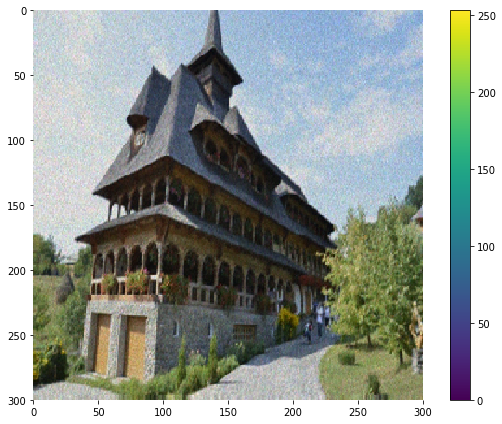

In [11]:
ishow(list(valid_mod_ds)[0][0])

Rescale all the datasets:

In [12]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image

#tmp = ds_valid_img.map(lambda x: tf.cast(x, tf.float32))
#ds_valid_img = tmp.map(scaling)

valid_mod_ds = valid_mod_ds.map(lambda x: tf.cast(x, tf.float32)).map(scaling)
valid_orig_ds = valid_orig_ds.map(lambda x: tf.cast(x, tf.float32)).map(scaling)
train_mod_ds = train_mod_ds.map(lambda x: tf.cast(x, tf.float32)).map(scaling)
train_orig_ds = train_orig_ds.map(lambda x: tf.cast(x, tf.float32)).map(scaling)

In [13]:
list(valid_orig_ds)[0][0]

<tf.Tensor: shape=(300, 300, 3), dtype=float32, numpy=
array([[[0.4627451 , 0.5294118 , 0.5882353 ],
        [0.4509804 , 0.5176471 , 0.5803922 ],
        [0.43137255, 0.49803922, 0.56078434],
        ...,
        [0.69803923, 0.7254902 , 0.7529412 ],
        [0.69411767, 0.72156864, 0.74509805],
        [0.69803923, 0.7254902 , 0.7490196 ]],

       [[0.44313726, 0.5176471 , 0.58431375],
        [0.4392157 , 0.5058824 , 0.5686275 ],
        [0.43137255, 0.49803922, 0.56078434],
        ...,
        [0.7019608 , 0.7294118 , 0.7529412 ],
        [0.7019608 , 0.73333335, 0.7490196 ],
        [0.7019608 , 0.7294118 , 0.7529412 ]],

       [[0.44705883, 0.5137255 , 0.57254905],
        [0.43529412, 0.5019608 , 0.5647059 ],
        [0.43137255, 0.49803922, 0.56078434],
        ...,
        [0.7058824 , 0.7372549 , 0.7490196 ],
        [0.7058824 , 0.7372549 , 0.7490196 ],
        [0.7058824 , 0.7372549 , 0.7490196 ]],

       ...,

       [[0.53333336, 0.50980395, 0.2901961 ],
        [0.58

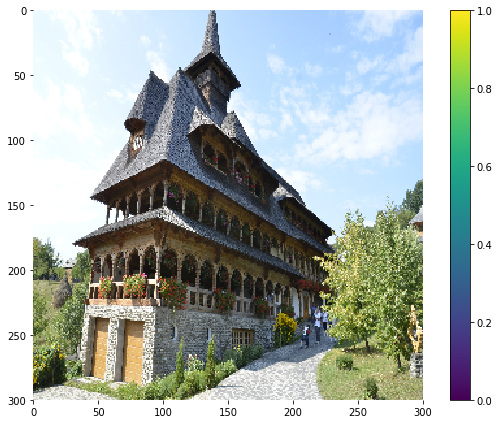

In [14]:
ishow(list(valid_orig_ds)[0][0])

## Crop and resize images

In [15]:
# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y

In [16]:
train_mod_ds = train_mod_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_mod_ds = train_mod_ds.prefetch(buffer_size=32)

train_orig_ds = train_orig_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_orig_ds = train_orig_ds.prefetch(buffer_size=32)

valid_mod_ds = valid_mod_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_mod_ds = valid_mod_ds.prefetch(buffer_size=32)

valid_orig_ds = valid_orig_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_orig_ds = valid_orig_ds.prefetch(buffer_size=32)

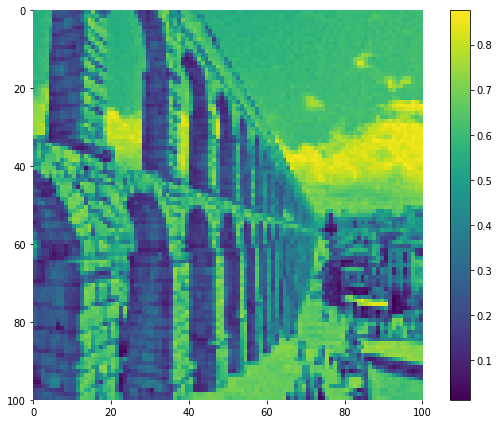

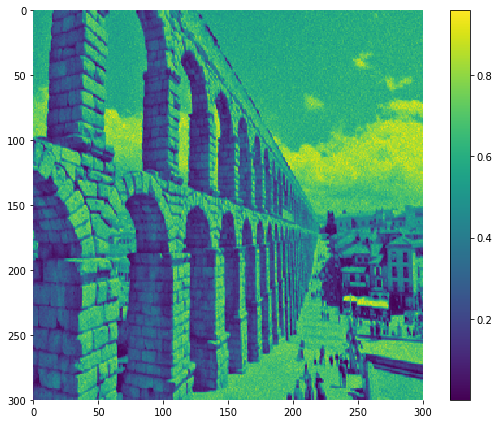

In [17]:
for batch in train_mod_ds.take(1):
    for img in batch[0]:
        ishow(img)
    for img in batch[1]:
        ishow(img)


In [18]:
def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "Orthogonal",
        "padding": "same",
    }
    inputs = tf.keras.Input(shape=(None, None, channels))
    x = tf.keras.layers.Conv2D(64, 5, **conv_args)(inputs)
    x = tf.keras.layers.Conv2D(64, 3, **conv_args)(x)
    x = tf.keras.layers.Conv2D(32, 3, **conv_args)(x)
    x = tf.keras.layers.Conv2D(channels * (upscale_factor ** 2), 3, **conv_args)(x)
    outputs = tf.nn.depth_to_space(x, upscale_factor)

    return tf.keras.Model(inputs, outputs)

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array
from IPython.display import display
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img


In [20]:
from tensorflow.keras.preprocessing.image import load_img
import math

class ESPCNCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super(ESPCNCallback, self).__init__()
        self.test_img = get_lowres_image(load_img(original_valid + "/0801.png"), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))


In [21]:
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "./tmp/checkpoint"

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
#callbacks = [early_stopping_callback, model_checkpoint_callback]

loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 64)    1664      
                                                                 
 conv2d_1 (Conv2D)           (None, None, None, 64)    36928     
                                                                 
 conv2d_2 (Conv2D)           (None, None, None, 32)    18464     
                                                                 
 conv2d_3 (Conv2D)           (None, None, None, 9)     2601      
                                                                 
 tf.nn.depth_to_space (TFOpL  (None, None, None, 1)    0         
 ambda)                                                          
                                                             

Epoch 1/20
Mean PSNR for epoch: 20.94


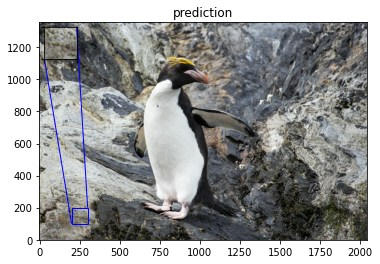

800/800 - 17s - loss: 0.0056 - val_loss: 0.0082 - 17s/epoch - 22ms/step
Epoch 2/20
Mean PSNR for epoch: 20.91
800/800 - 10s - loss: 0.0028 - val_loss: 0.0082 - 10s/epoch - 12ms/step
Epoch 3/20
Mean PSNR for epoch: 21.00
800/800 - 10s - loss: 0.0027 - val_loss: 0.0081 - 10s/epoch - 12ms/step
Epoch 4/20
Mean PSNR for epoch: 21.01
800/800 - 9s - loss: 0.0030 - val_loss: 0.0080 - 9s/epoch - 12ms/step
Epoch 5/20
Mean PSNR for epoch: 21.03
800/800 - 9s - loss: 0.0026 - val_loss: 0.0080 - 9s/epoch - 12ms/step
Epoch 6/20
Mean PSNR for epoch: 21.03
800/800 - 9s - loss: 0.0026 - val_loss: 0.0080 - 9s/epoch - 12ms/step
Epoch 7/20
Mean PSNR for epoch: 21.01
800/800 - 9s - loss: 0.0028 - val_loss: 0.0080 - 9s/epoch - 12ms/step
Epoch 8/20
Mean PSNR for epoch: 21.06
800/800 - 10s - loss: 0.0026 - val_loss: 0.0079 - 10s/epoch - 12ms/step
Epoch 9/20
Mean PSNR for epoch: 21.05
800/800 - 10s - loss: 0.0025 - val_loss: 0.0079 - 10s/epoch - 12ms/step
Epoch 10/20
Mean PSNR for epoch: 21.06
800/800 - 10s - l

In [22]:
epochs = 20

model.compile(
    optimizer=optimizer, loss=loss_fn,
)

model.fit(
    train_mod_ds, epochs=epochs, callbacks=callbacks, validation_data=train_orig_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)


In [30]:
import os

test_img_paths = sorted(
    [
        os.path.join(original_valid + "/", fname)
        for fname in os.listdir(original_valid + "/")
        if fname.endswith(".png")
    ]
)

In [31]:
test_img_paths

['./../dataset/DIV2K_valid_HR/0801.png',
 './../dataset/DIV2K_valid_HR/0802.png',
 './../dataset/DIV2K_valid_HR/0803.png',
 './../dataset/DIV2K_valid_HR/0804.png',
 './../dataset/DIV2K_valid_HR/0805.png',
 './../dataset/DIV2K_valid_HR/0806.png',
 './../dataset/DIV2K_valid_HR/0807.png',
 './../dataset/DIV2K_valid_HR/0808.png',
 './../dataset/DIV2K_valid_HR/0809.png',
 './../dataset/DIV2K_valid_HR/0810.png',
 './../dataset/DIV2K_valid_HR/0811.png',
 './../dataset/DIV2K_valid_HR/0812.png',
 './../dataset/DIV2K_valid_HR/0813.png',
 './../dataset/DIV2K_valid_HR/0814.png',
 './../dataset/DIV2K_valid_HR/0815.png',
 './../dataset/DIV2K_valid_HR/0816.png',
 './../dataset/DIV2K_valid_HR/0817.png',
 './../dataset/DIV2K_valid_HR/0818.png',
 './../dataset/DIV2K_valid_HR/0819.png',
 './../dataset/DIV2K_valid_HR/0820.png',
 './../dataset/DIV2K_valid_HR/0821.png',
 './../dataset/DIV2K_valid_HR/0822.png',
 './../dataset/DIV2K_valid_HR/0823.png',
 './../dataset/DIV2K_valid_HR/0824.png',
 './../dataset/D

PSNR of low resolution image and high resolution image is 28.1927
PSNR of predict and high resolution is 28.7598


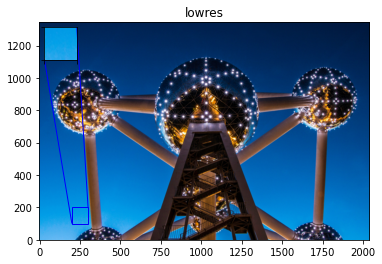

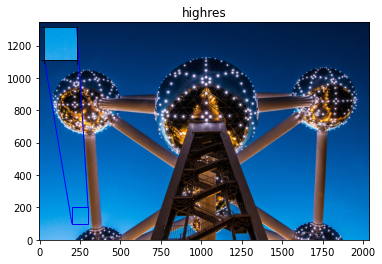

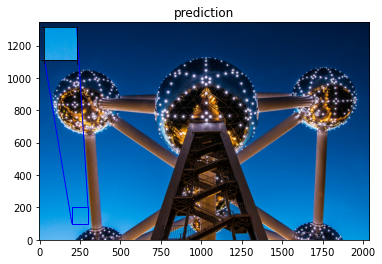

PSNR of low resolution image and high resolution image is 30.1930
PSNR of predict and high resolution is 30.6727


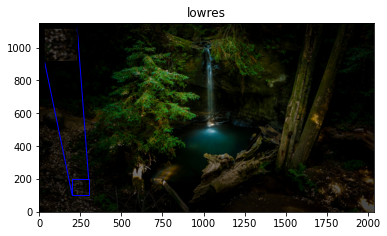

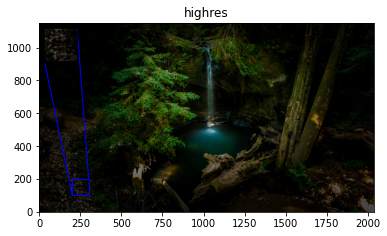

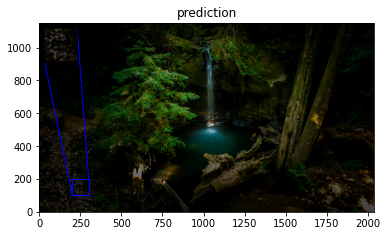

PSNR of low resolution image and high resolution image is 33.3164
PSNR of predict and high resolution is 34.1592


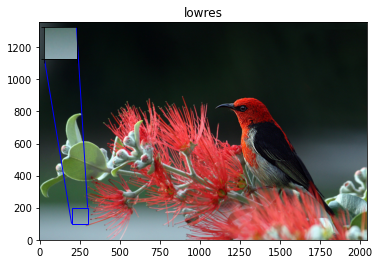

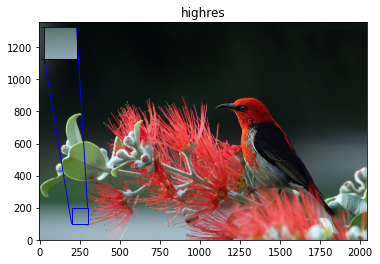

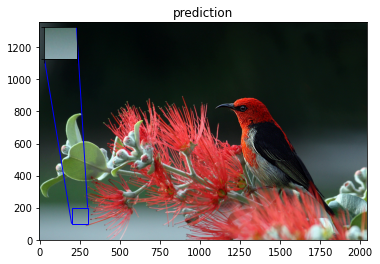

PSNR of low resolution image and high resolution image is 24.6446
PSNR of predict and high resolution is 25.3344


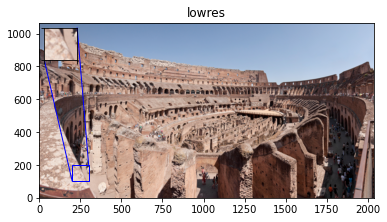

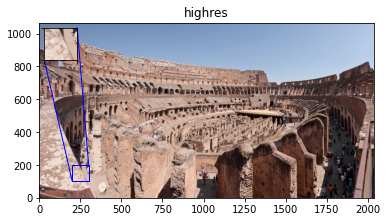

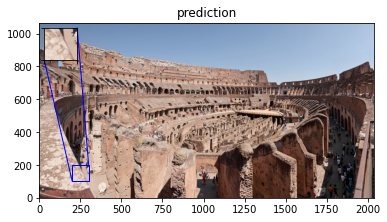

PSNR of low resolution image and high resolution image is 29.4664
PSNR of predict and high resolution is 29.9608


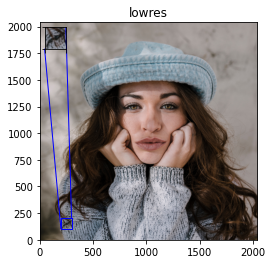

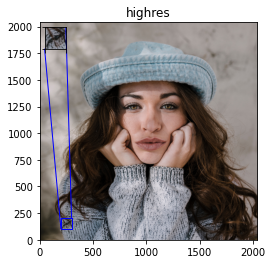

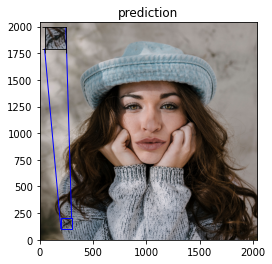

PSNR of low resolution image and high resolution image is 24.8135
PSNR of predict and high resolution is 25.1814


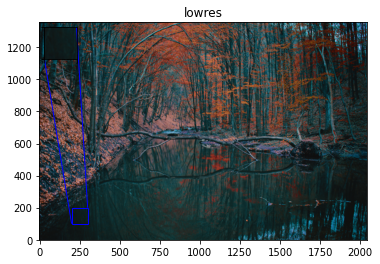

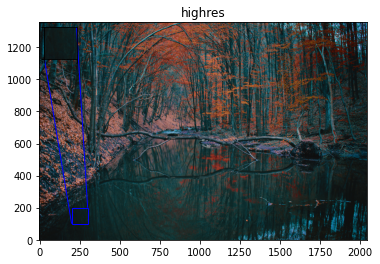

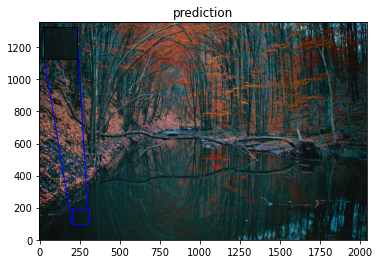

PSNR of low resolution image and high resolution image is 34.6558
PSNR of predict and high resolution is 34.0517


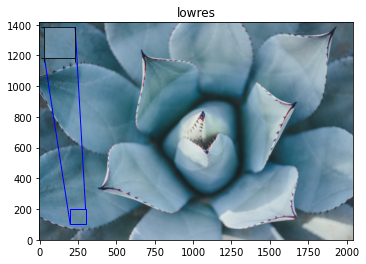

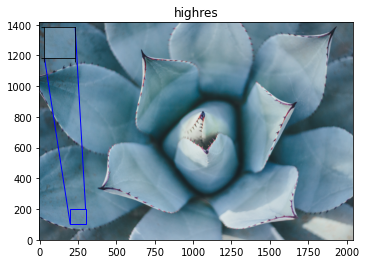

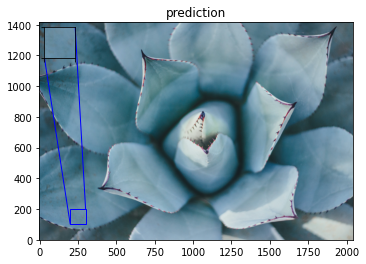

PSNR of low resolution image and high resolution image is 28.4928
PSNR of predict and high resolution is 29.1149


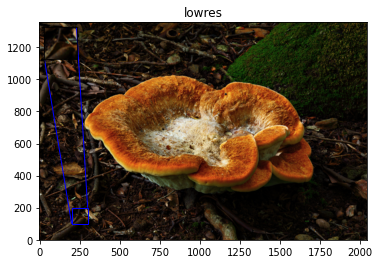

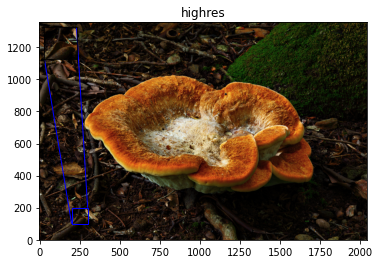

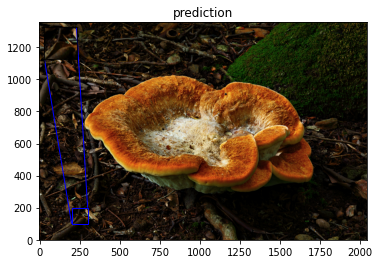

PSNR of low resolution image and high resolution image is 25.4811
PSNR of predict and high resolution is 26.0923


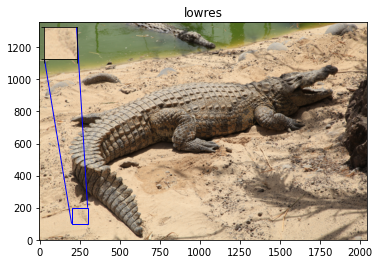

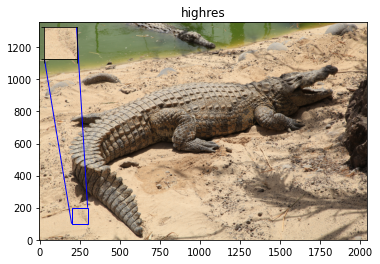

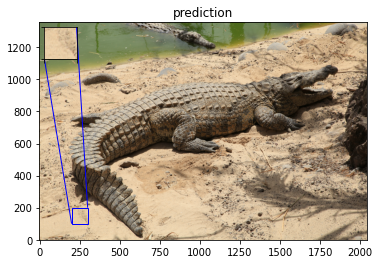

PSNR of low resolution image and high resolution image is 20.8100
PSNR of predict and high resolution is 21.3831


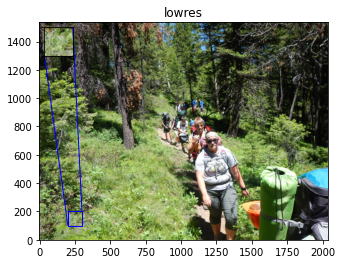

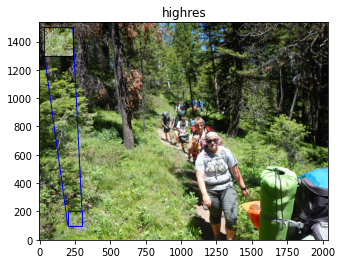

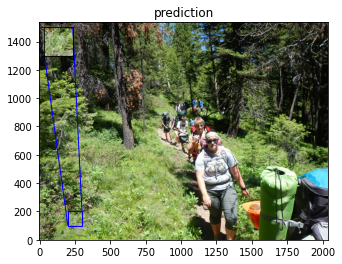

Avg. PSNR of lowres images is 28.0066
Avg. PSNR of reconstructions is 28.4710


In [32]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))
